# Analisis de la movilidad urbana utilizando estadisticas del Comoir

En este notebook intento realizar un analisis geoespacial de la movilidad urbana utilizando como fuente de datos las estadisticas de uso de la aplicacion Comoir publicadas por la IMM.

Primero lo primero - Las librerias que voy a precisar!

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import shapely
from pyproj import Proj, transform
import os
import sys
import zipfile
from six.moves.urllib.request import urlretrieve
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource

%matplotlib inline

## Algunas cosas que voy a precisar luego

Defino algunas constantes que me van a servir a lo largo del notebook. Dado que los archivos con los datos son unos cuantos y ocupan en total cerca de 1 GB, en lugar de subirlos a github, utilizo algunas funciones que tome prestadas de un curso sobre TensorFlow para descargar los archivos en caso de ser necesarios.

In [2]:
SEPARADOR = ';'
AÑO = 2011

urlGis = 'http://intgis.montevideo.gub.uy/sit/tmp/'
urlImm = 'http://www.montevideo.gub.uy/sites/default/files/datos/'

last_percent_reported = None

data_dict = {2010:('../data/comoir','comoir_2010_01_12.csv.gz'), 
             2011:('../data/comoir','comoir_2011_01_12.csv.gz'), 
             2012:('../data/comoir','comoir_2012_01_12.csv.gz'), 
             2013:('../data/comoir','comoir_2013_01_12.csv.gz'), 
             2014:('../data/comoir','comoir_2014_01_06.csv.gz')}

barrios_shp_path = '../data/barrios_limites/barrios.shp' #shapefile con los barrios de montevideo
vias_shp_path = '../data/v_mdg_vias/v_mdg_vias.shp' #shapefile con las vias (calles, caminos, pasajes, etc.) de mvdeo
destino_shp_path = '../data/v_uptu_lsv_destinos/v_uptu_lsv_destinos.shp' #shapefile con los destino... ni se porque lo baje
ejes_shp_path = '../data/ejesinv/ejesinv.shp' # ejes de las calles. Tiene todas llas "cuadras" de cada calle.
codpost_shp_path = '../data/cpost/cpost.shp' # poligonos de los distintos codigos postales de montevideo 

manzanas_shp_path = '../data/v_mdg_manzanas/v_mdg_manzanas.shp' #shapefile con las manzanas
accesos_shp_path = '../data/v_mdg_accesos/v_mdg_accesos.shp' #shapefile con las calles y su numeracion. 
cultura_csv_path = '../data/v_uptu_lugares/uptu_cultura.zip' #shapefile con la ubicacion de los centros culturales
deporte_csv_path = '../data/v_uptu_lugares/uptu_deporte.zip' #shapefile con los lugares centros deportivos
educacion_csv_path = '../data/v_uptu_lugares/uptu_educacion.zip' #shapefile con los centros educativos 
patrimonio_csv_path = '../data/v_uptu_lugares/uptu_patrimonio.zip' #shapefile con los lugares patrimoniales
playa_csv_path = '../data/v_uptu_lugares/uptu_playa.zip' #shapefile con las playas
salud_csv_path = '../data/v_uptu_lugares/uptu_salud.zip' #shapefile con los centros de salud
espacios_shp_path = '../data/v_mdg_espacios_libres/v_mdg_espacios_libres.shp' #shapefile de espacios libres (parques, plazas, etc)
monumentos_shp_path = '../data/v_mdg_ubicaciones_notables/v_mdg_ubicaciones_notables.shp' #shapefile de monumentos

---
Estas funciones sirven para descargar los archivos en forma progresiva; despues de todo no todos tenemos la misma velocidad de conexion.


In [3]:
def download_progress_hook(count, blockSize, totalSize):
    """ 
        A hook to report the progress of a download. This is mostly intended 
        for users with slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(url, filename, directory, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(directory, filename)
    os.makedirs(name=directory, exist_ok=True) # Attempt to create the dir where the file should be downloaded to. If exists then do nothing
    if force or not os.path.exists(dest_filename):
        print('Iniciando Descarga:', url + filename) 
        try:
            filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
            print('Descarga Completa!')
        except:
            print('%s no se pudo descargar!' % filename)
    else:
        print('%s ya existe en la carpeta - Salteando la descarga.' % dest_filename) 
    
    return dest_filename

def maybe_extract(filename, destination, force=False):
    root = os.path.splitext(filename)[0]  # remove extension .gz, .zip
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s ya existe - Salteando la extraccion.' % root) 
    else:
        print('Descomprimiendo %s. Puede tomar unos minutos. Por favor espere.' % root) 
        gz = zipfile.ZipFile(filename)
        sys.stdout.flush()
        gz.extractall(destination)

        gz.close()

---

Esta funcion la utilizare mas adelante para descomponer un shapely.Point en sus coordenadas x e y.

In [4]:
def get_point(punto):
    if isinstance(punto, shapely.geometry.Point):
        return punto
    elif isinstance(punto, shapely.geometry.MultiPoint):
        return punto.centroid
    else:
        return np.nan

In [5]:
%%time
filename = maybe_download(urlImm, 'uptu_cultura.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_deporte.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_educacion.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_patrimonio.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_playa.zip', '../data/v_uptu_lugares')
filename = maybe_download(urlImm, 'uptu_salud.zip', '../data/v_uptu_lugares')

filename = maybe_download(urlImm, 'barrios_limites.zip', '../data')
maybe_extract(filename, destination='../data/barrios_limites')

filename = maybe_download(urlGis, 'v_mdg_vias.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_vias')

filename = maybe_download(urlGis, 'v_mdg_accesos.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_accesos')

filename = maybe_download(urlGis, 'v_mdg_ubicaciones_notables.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_ubicaciones_notables')

filename = maybe_download(urlGis, 'v_mdg_espacios_libres.zip', '../data')
maybe_extract(filename, destination='../data/v_mdg_espacios_libres')

#filename = maybe_download(urlImm, 'comoir_2010_01_12.csv.gz', '../data/comoir')
filename = maybe_download(urlImm, data_dict[AÑO][1], data_dict[AÑO][0])

../data/v_uptu_lugares/uptu_cultura.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_deporte.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_educacion.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_patrimonio.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_playa.zip ya existe en la carpeta - Salteando la descarga.
../data/v_uptu_lugares/uptu_salud.zip ya existe en la carpeta - Salteando la descarga.
../data/barrios_limites.zip ya existe en la carpeta - Salteando la descarga.
../data/barrios_limites ya existe - Salteando la extraccion.
../data/v_mdg_vias.zip ya existe en la carpeta - Salteando la descarga.
../data/v_mdg_vias ya existe - Salteando la extraccion.
../data/v_mdg_accesos.zip ya existe en la carpeta - Salteando la descarga.
../data/v_mdg_accesos ya existe - Salteando la extraccion.
../data/v_mdg_ubicaciones_notables.zip ya existe en la carpeta - 

## La estrategia

Los datos con las estadisticas estan separados en 1 archivo por año. Del 2010 al 2013 inclusive, contienen la información de todo el año, mientras que el 2014 solo incluye información del primer semestre de ese año. Las busquedas que se pueden hacer en Comoir son de 3 tipos por cada punto del recorrido (origen y destino) lo que da un total de 6 tipos diferentes combinados. Las busquedas pueden hacerse por:
    - Esquina: curce de calles
    - Dirección: calle y número
    - Lugar de interés

Cada csv indica el tipo de origen, el tipo de destino, y para cada uno de ellos se indica 1 o 2 códigos. Si el tipo del punto es dirección o lugar de interes, el código identifica la calle o el lugar de interes respectivamente. Si el tipo del punto es esquina, se indican dos codigos, donde el primero identifica una calle y el segundo la otra. Los códigos hacen referencia a los otros shapefile, para las calles se hace referencia a vias_shp_path, y para lugares de interes se hace referencia a cultura_shp_path, deporte_shp_path, educacion_shp_path, patrimonio_shp_path, playa_shp_path, salud_shp_path, espacios_shp_path y monumentos_shp_path. Para las direcciones numeradas (calle y numero de puerta) se hace referencia al shapefile accesos_shp_path.

En esta version en lugar de utilizar el dataframe de consultas "crudo" lo reducimos a todos los diferentes destinos consultados agregando la cantidad de consultas realizadas para cada uno de ellos. De esta forma si bien el join con cada "codiguera" sigue siendo conceptualmente igual, es mucho mas rapido debido a la reduccion en volumen. El join con los lugares de interes se realiza mediante el codigo del destino (que identifica el lugar de interes). Con las direcciones se hace el join por nombre (nombre de calle y nro de puerta) y el join con las esquinas se realiza mediante el codigo_detsino_1 y el codigo_destino_2. A este ultimo se agrega un paso mas para encontrar el punto de interseccion de ambas calles.

In [6]:
%%time
#Levanto los lugares de interes y agrego a cada dataframe el tipo y las coordenadas (x,y)
cu = pd.read_csv(cultura_csv_path, delimiter=SEPARADOR)      #cultura         - tipo 3
de = pd.read_csv(deporte_csv_path, delimiter=SEPARADOR)      #deporte         - tipo 4
ed = pd.read_csv(educacion_csv_path, delimiter=SEPARADOR)    #educacion       - tipo 5
pa = pd.read_csv(patrimonio_csv_path, delimiter=SEPARADOR)   #patrimonio      - tipo 9
pl = pd.read_csv(playa_csv_path, delimiter=SEPARADOR)        #playa           - tipo 10
sa = pd.read_csv(salud_csv_path, delimiter=SEPARADOR)        #salud           - tipo 11
el = gpd.read_file(espacios_shp_path)   #espacios libres - tipo 6 espacio libre
pq = el[np.isfinite(el['COD_NOM_PA'])]  #parques         - tipo 7
el = el[np.isfinite(el['COD_NOM_ES'])]  #espacio libre   - tipo 6
mo = gpd.read_file(monumentos_shp_path) #monumentos      - tipo 8

cu.loc[:,'tipo'] = 3
cu.loc[:,'punto'] = cu[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
de.loc[:,'tipo'] = 4
de.loc[:,'punto'] = de[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
ed.loc[:,'tipo'] = 5
ed.loc[:,'punto'] = ed[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
pa.loc[:,'tipo'] = 9
pa.loc[:,'punto'] = pa[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
pl.loc[:,'tipo'] = 10
pl.loc[:,'punto'] = pl[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
sa.loc[:,'tipo'] = 11
sa.loc[:,'punto'] = sa[['x', 'y']].apply(lambda r: shapely.geometry.Point(r.x,r.y), axis=1)
el.loc[:,'tipo'] = 6
el.loc[:,'codigo'] = el['COD_NOM_ES'].apply(lambda c: c)
el.loc[:,'punto'] = el['geometry'].apply(lambda p: p.centroid)
pq.loc[:,'tipo'] = 7
pq.loc[:,'codigo'] = pq['COD_NOM_PA'].apply(lambda c: c)
pq.loc[:,'punto'] = pq['geometry'].apply(lambda p: p.centroid)
mo.loc[:,'punto'] = mo['geometry'].apply(lambda p: p)
mo = mo.dropna(subset=['COD_NOM_UB'])
mo.loc[:,'tipo'] = 8
mo.loc[:,'codigo'] = mo['COD_NOM_UB'].apply(lambda c: c)

#Unifico todos los lugares de interes en un solo dataframe con el codigo, tipo y las coordenadas (x,y) de cada uno.
lugares_interes = cu.append(de.append(ed.append(pa.append(pl.append(sa.append(pq.append(el.append(mo,ignore_index=True),
                                                                              ignore_index=True),
                                                                    ignore_index=True),
                                                          ignore_index=True),
                                                ignore_index=True),
                                      ignore_index=True), 
                            ignore_index=True), 
                  ignore_index=True)
lugares_interes = lugares_interes[['nombre', 'codigo', 'tipo', 'punto']]

CPU times: user 815 ms, sys: 23.3 ms, total: 838 ms
Wall time: 905 ms


In [7]:
%%time
#Levanto las "cuadras" de cada calle y las agrupo por codigo para luego unir todas las cuadras de cada calle en una sola coleccion
calles = gpd.read_file(vias_shp_path) 
calles = calles.groupby('COD_NOMBRE')['geometry'].agg({'geometry': lambda x: shapely.ops.linemerge(x.values)})
calles.loc[:,'codigo'] = calles.index
calles.loc[:,'tipo'] = 1

CPU times: user 8.26 s, sys: 80.1 ms, total: 8.34 s
Wall time: 8.36 s


In [8]:
%%time
#Levanto las calles con su numeracion
c_nums = gpd.read_file(accesos_shp_path) 
c_nums.loc[:,'direccion'] = c_nums['NOM_CALLE'] + ' ' + c_nums['NUM_PUERTA'].map(str)
c_nums.loc[:,'punto'] = c_nums['geometry'].apply(lambda p: p)
c_nums.loc[:,'tipo'] = 2
c_nums = c_nums[['COD_NOMBRE', 'tipo', 'direccion','punto']] #para cada direccion posible tengo las coordenadas (x,y).

CPU times: user 16.7 s, sys: 533 ms, total: 17.2 s
Wall time: 17.3 s


---
Esta funcion levanta un csv correspondiente a las consultas para una año especifico, lo reduce a los diferentes destinos consultados con la cantidad de consultas por cada destino y agrega el punto correspondiente en el mapa. Retorna un GeoDataFrame.

In [9]:
def load_data(year):
    #Levanto las consultas realizadas en la aplicacion.
    #Para variar el año de la consulta modificar la constante AÑO
    csvfile = data_dict[year][0] + '/' + data_dict[year][1]
    cir_data = pd.read_csv(csvfile, low_memory=False, delimiter=SEPARADOR)
    cir_data['codigo_destino_1'].fillna(value=0,inplace=True)
    cir_data['codigo_destino_2'].fillna(value=0,inplace=True)

    comoir = pd.DataFrame({'Busquedas': cir_data.groupby(['tipo_destino', 'codigo_destino_1', 
                                                          'codigo_destino_2', 'desc_destino']).size()}).reset_index()

    #Hago el merge de los lugares de interes con las consultas para asociar a cada consulta las coordenadas
    d_li = comoir.merge(lugares_interes, left_on=['codigo_destino_1', 'tipo_destino'], 
                        right_on=['codigo', 'tipo'], how='inner')

    #Hago el merge de las consultas con las calles para asociar a cada una los dos shape que definen la esquina
    d_cc = comoir.merge(calles, left_on=['codigo_destino_1', 'tipo_destino'], right_on=['codigo', 'tipo'], how='inner')\
                    .merge(calles, left_on=['codigo_destino_2', 'tipo_destino'], right_on=['codigo', 'tipo'], how='inner')

    d_cn = comoir.merge(c_nums, left_on=['desc_destino'], right_on=['direccion'], how='inner')

    d_li = d_li[['tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'punto', 'Busquedas']]
    d_cn = d_cn[['tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'punto', 'Busquedas']]
    d_cc = d_cc[['tipo_destino', 'codigo_destino_1', 'codigo_destino_2', 'desc_destino', 'geometry_x', 'geometry_y', 'Busquedas']]
    d_cc = d_cc.rename(columns={'geometry_x': 'geometry_d1', 'geometry_y': 'geometry_d2'})

    d_cc['punto'] = d_cc.apply(lambda row: get_point(row.geometry_d1.intersection(row.geometry_d2)), axis=1)
    d_cc = d_cc.dropna(subset=['punto'])

    destinos = d_li.append(d_cn.append(d_cc, ignore_index=True), ignore_index=True)

    destinos = destinos.rename(columns={'punto': 'geometry'})
    destinos = destinos.drop(['geometry_d1','geometry_d2'], axis=1)

    destinos['codigo_destino_1'].fillna(value=0,inplace=True)
    destinos['codigo_destino_2'].fillna(value=0,inplace=True)
    
    gds = gpd.GeoDataFrame(destinos, crs={'init': 'epsg:31981'}, geometry='geometry')
    
    return gds

---

Despues de levantar la informacion de los barrios en un GeoDataFrame hacemos un join espacial entre el GDF *barrios* y los GDF generados por la funcion *load_data* para cada año. El GDF *barrios* termina con una columna BYYYY para cada año del 2010 al 2014 en la que se guarda la cantidad de consultas realizadas para cada año dentro de ese barrio.

In [10]:
%%time 
barrios = gpd.read_file(barrios_shp_path)
barrios.index = barrios.NROBARRIO
barrios.crs = crs={'init': 'epsg:31981'}

for year, _ in data_dict.items():
    destsEnBarrios = gpd.tools.sjoin(barrios, load_data(year), how='left')
    barrios.loc[:, 'B'+str(year)] = destsEnBarrios.groupby('NROBARRIO')['Busquedas'].sum()

CPU times: user 4min 16s, sys: 8.27 s, total: 4min 24s
Wall time: 4min 27s


---
Matplotlib
----------
Tomando el dataframe **barrios** ploteo la columna *Busquedas* usando el esquema Fisher Jenks y Quintiles con dos esquemas de colores diferentes, uno de 5 colores y otro de 10. A ver cual es mejor.

---
**Fisher Jenks - 10 colores**

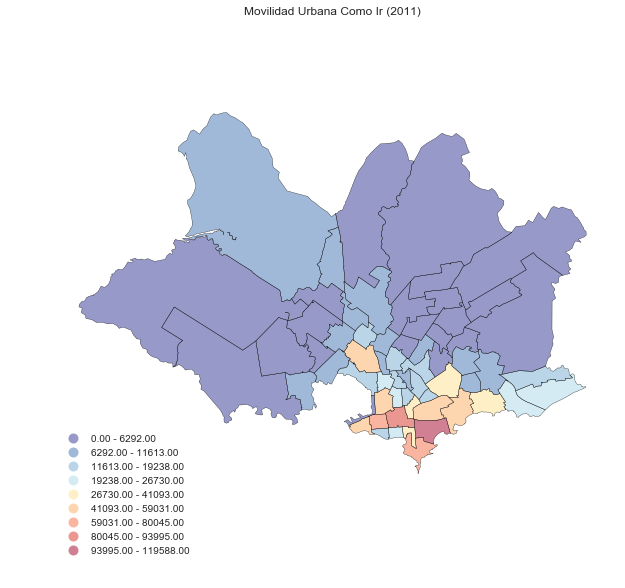

In [11]:
cmap10 = colors.ListedColormap(['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8', '#fee090','#fdae61','#f46d43','#d73027','#a50026'])

f, ax = plt.subplots(1, figsize=(10, 10))
barrios.plot(column='B2011', scheme='fisher_jenks', legend=True, k=9,
             ax=ax, cmap=cmap10, linewidth=0.3)
ax.set_axis_off()
ax.set_title("Movilidad Urbana Como Ir (2011)")
plt.axis('equal')
plt.show()

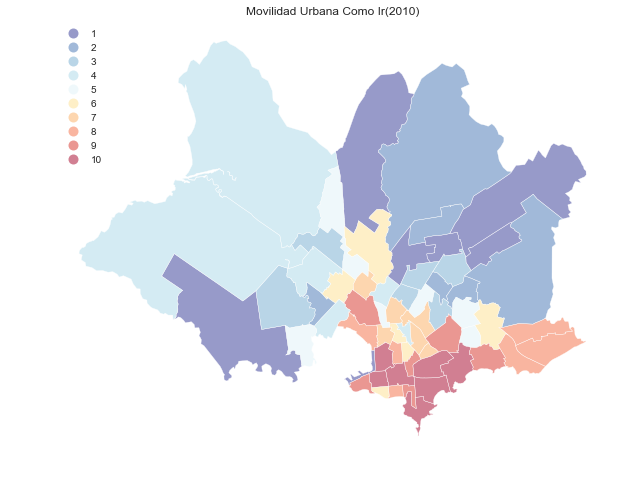

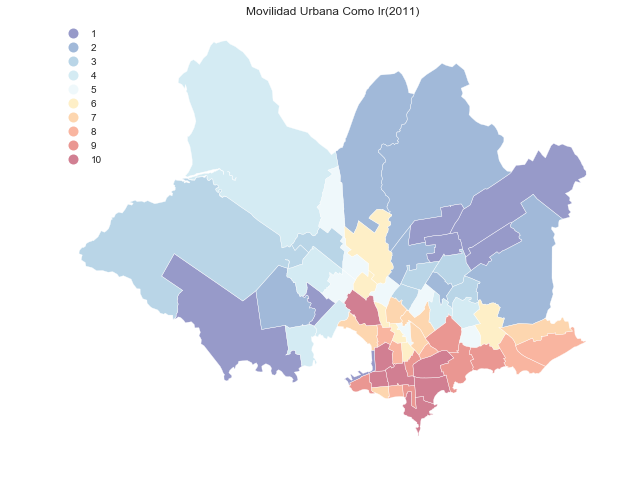

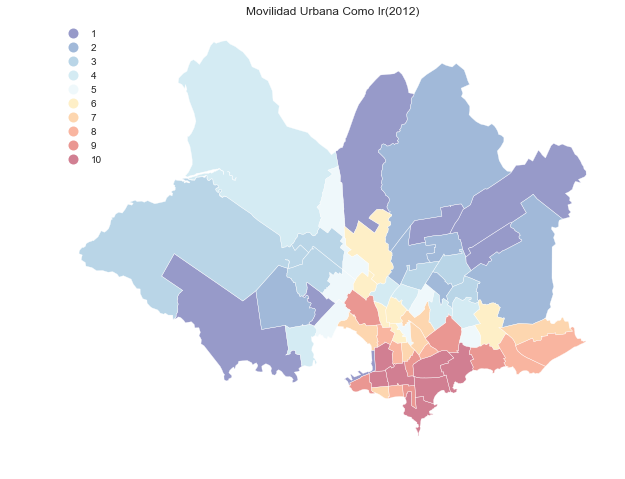

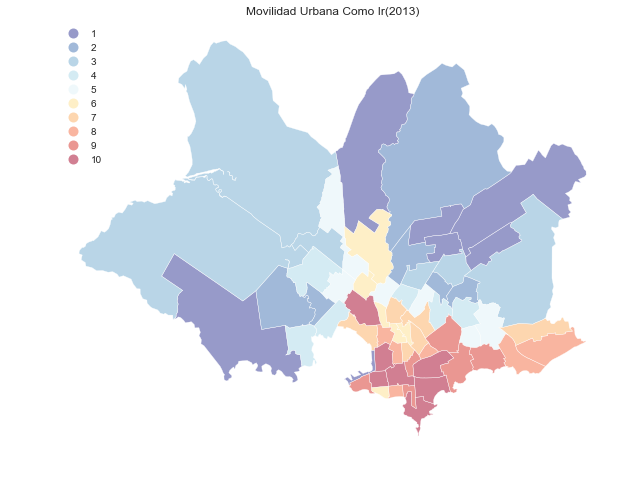

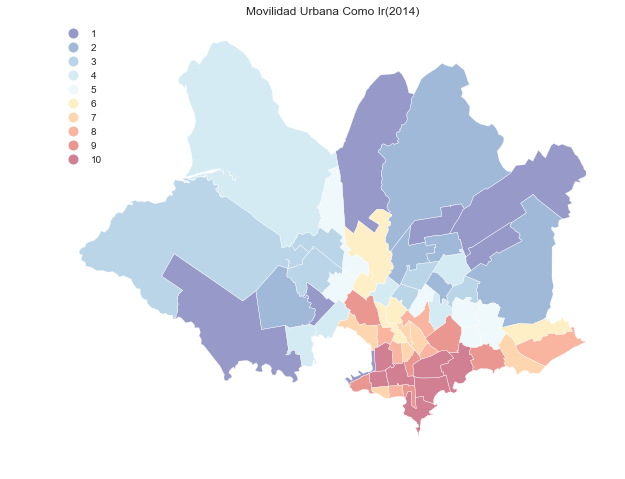

In [13]:
for y in range(2010,2015):
    by = ps.Quantiles(barrios['B'+str(y)].values, k=10)
    f, ax = plt.subplots(1, figsize=(10, 8))
    barrios.assign(cl=by.yb+1).plot(column='cl', categorical=True, \
            k=10, cmap=cmap10, linewidth=0.3, ax=ax, \
            edgecolor='White', legend=True)
    ax.set_axis_off()
    plt.title("Movilidad Urbana Como Ir(%d)"%y)
    plt.show()

---
**Quintiles - 10 colores**

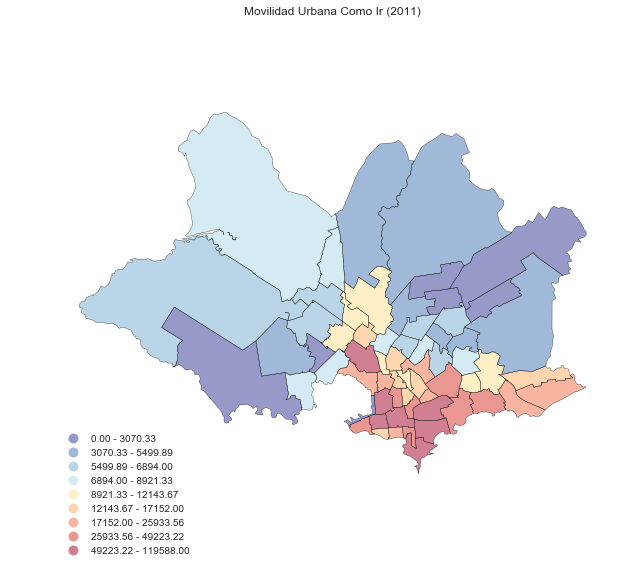

In [14]:
cmap10 = colors.ListedColormap(['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8', '#fee090','#fdae61','#f46d43','#d73027','#a50026'])

f, ax = plt.subplots(1, figsize=(10, 10))
barrios.plot(column='B2011', scheme='quantiles', legend=True, k=9,
             ax=ax, cmap=cmap10, linewidth=0.3)
ax.set_axis_off()
ax.set_title("Movilidad Urbana Como Ir (2011)")
plt.axis('equal')
plt.show()

---
**Fisher Jenks - 5 colores**

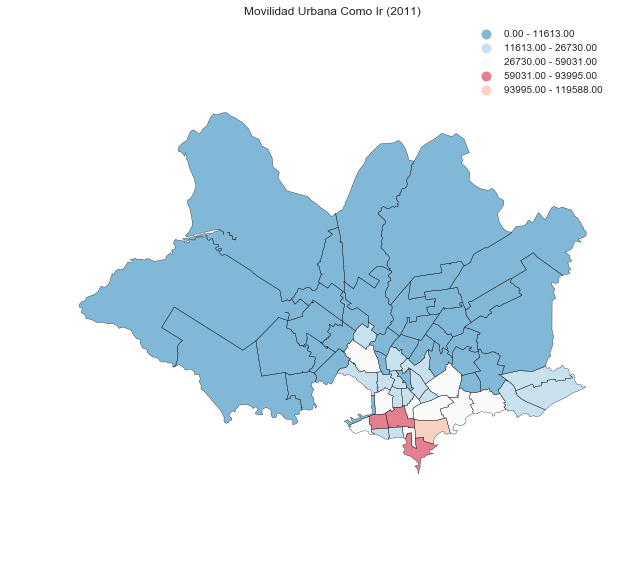

In [15]:
cmap5 = colors.ListedColormap(['#0571b0', '#92c5de','#f7f7f7','#ca0020','#f4a582'])

f, ax = plt.subplots(1, figsize=(10, 10))
barrios.plot(column='B2011', scheme='fisher_jenks', legend=True, k=5,
             ax=ax, cmap=cmap5, linewidth=0.3)
ax.set_axis_off()
ax.set_title("Movilidad Urbana Como Ir (2011)")
plt.axis('equal')
plt.show()

---
**Quintiles - 5 colores**

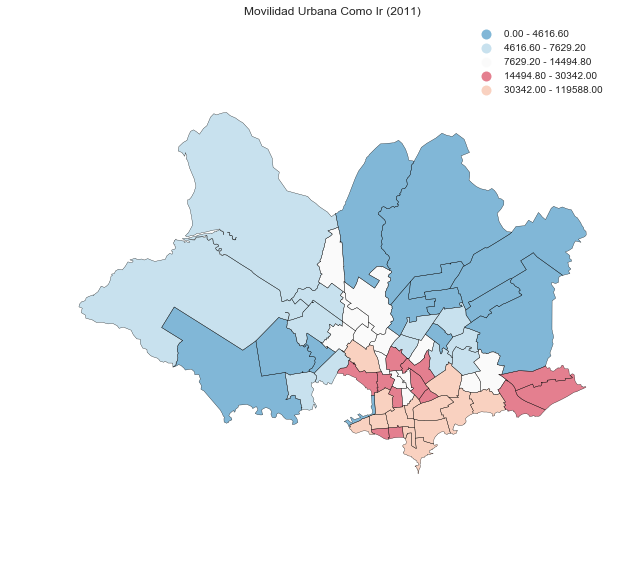

In [16]:
cmap5 = colors.ListedColormap(['#0571b0', '#92c5de','#f7f7f7','#ca0020','#f4a582'])

f, ax = plt.subplots(1, figsize=(10, 10))
barrios.plot(column='B2011', scheme='Quantiles', legend=True, k=5,
             ax=ax, cmap=cmap5, linewidth=0.3)
ax.set_axis_off()
ax.set_title("Movilidad Urbana Como Ir (2011)")
plt.axis('equal')
plt.show()

---
Bokeh
-----

Ahora pruebo usando Bokeh y PySal para graficar deciles. PySal lo utilizo para dividir la serie de Busquedas en deciles (usando la funciona Quantiles k=10) y luego con Bokeh lo grafico armando un mapa interactivo 

In [17]:
#['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
#['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
b201x = np.array(barrios.B2011)
bins_qk = ps.Quantiles(b201x, k=10)
colorsk = ['#313695','#4575b4','#74add1','#abd9e9','#e0f3f8','#fee090','#fdae61','#f46d43','#d73027','#a50026']#['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
colors = [colorsk[i] for i in bins_qk.yb]

In [18]:
def gpd_bokeh(df):
    """Convert geometries from geopandas to bokeh format"""
    nan = float('nan')
    lons = []
    lats = []
    for i,shape in enumerate(df.geometry.values):
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)
                
        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 

    return lons,lats

In [19]:
lons, lats = gpd_bokeh(barrios)

source = ColumnDataSource(data=dict(
        x=lons,
        y=lats,
        color=colors,
        name=barrios.BARRIO,
        rate=b201x
    ))

TOOLS = "pan, wheel_zoom, box_zoom, reset, hover, save"
p = figure(title="Movilidad Urbana Como Ir (" + str(AÑO) + ")", tools=TOOLS,
          plot_width=900, plot_height=600)

p.patches('x', 'y', source=source,
         fill_color='color', fill_alpha=0.7,
         line_color='white', line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [
    ("Barrio", "@name"),
    ("B"+ str(AÑO), "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]


output_file("comoir" + str(AÑO) + ".html", title="comoir" + str(AÑO) + ".py example")
show(p)